In [0]:
# Downloading the data from Kaggle API, since it's really slow on windows

import os
username = 'arashnourimand'
key = '8958f5601aace24552a78e2c692b9297'
os.environ['KAGGLE_USERNAME'] = username 
os.environ['KAGGLE_KEY'] = key

!kaggle competitions download -c histopathologic-cancer-detection #api link copied from kaggle competition

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 94.0MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 84.0MB/s]
 99% 1.29G/1.30G [00:23<00:00, 42.3MB/s]
100% 1.30G/1.30G [00:23<00:00, 59.1MB/s]
100% 4.97G/4.98G [00:52<00:00, 102MB/s] 
100% 4.98G/4.98G [00:52<00:00, 101MB/s]


In [0]:
# All of the data has been downladed, but it is still zipped. Exploratory data analysis of the 2 csv files

import pandas as pd #for the data conversions and analysis
from google.colab import drive #to access the data
from PIL import Image
from zipfile import ZipFile
import csv

drive.mount('/content/gdrive')

train_labels_path = '/content/train_labels.csv.zip'
train_pics_path = '/content/train.zip'
test_pics_path = '/content/test.zip'

with ZipFile(train_labels_path) as labelzip:
    labels_csv = labelzip.namelist()
    with labelzip.open(labels_csv[0]) as myfile:
        traincsvfile = myfile.read()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Convert the extracted csv file into an actual dataframe for analysis
labels_df = pd.read_csv('train_labels.csv.zip')
print(labels_df.describe(),'\n') # 1 = presence of cancerous tissue and 0 = non-cancerous 
print(labels_df['label'].value_counts()) #shows the number of values that are present

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000 

0    130908
1     89117
Name: label, dtype: int64


In [0]:
# Extraction of the training images
with ZipFile(train_pics_path) as myzip:
    pics_in_zip = myzip.namelist()
    #with myzip.open(pics_in_zip[0]) as myfile:
      #  img = Image.open(myfile)
num_train_pics = len(pics_in_zip)
print(num_train_pics) #number of pictures
print(pics_in_zip[0][:-4]) #image file name without the filetype (.tif)

220025
019ce31cc317087ca287f66ad757776952826594


In [0]:
#with the images able to be extracted, time to extract the information. First, must view the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#code to extract the picture information
sample_img_arr = []
for i in range(10):
  with ZipFile(train_pics_path) as myzip:
      with myzip.open(pics_in_zip[i]) as myfile:
          sample_img_arr.append(Image.open(myfile))

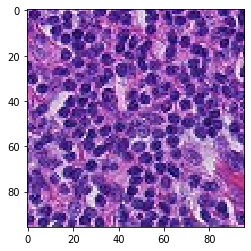

In [0]:
plt.imshow(sample_img_arr[0])

In [0]:
# Now that pictures are visible, it is time to make them black and white and extract the BW 
# information into numpy arrays

from PIL import Image

# First see how images can be as black and white --> this is so that the processing of data and predictions can be easier
color_img = sample_img_arr[4]
bw_img = color_img.convert('LA')
plt.imshow(bw_img)
 
# Below is a black and white image

NameError: ignored

In [0]:
# now it is time to create the image arrat

import numpy as np

pix_val = list(bw_img.getdata())
pix_val = np.asarray(pix_val) #shows the array as 9216 2 element vectors in form (x,y) where x = black intensity and y = white intensity
print(pix_val.shape)



NameError: ignored

In [0]:
"""
Create code to do the following:
  1) extract all of the images from the training images
  2) convert the images to grayscale
  3) extract the mean, median, and mode B and W image values from training data and append to a numpy array
  4) take the cancerous presency (0/1) of training data and append this as the target outcome
  5) repeat steps 3/4 for the test data
  6) train a logistic regression model as the baseline to assess the accuracy using these values
  
"""

In [0]:
# THIS CELL INCLUDES STEPS 1-3

img_list = []
# Extraction of the training images
with ZipFile(train_pics_path) as myzip:
    pics_in_zip = myzip.namelist() #gives the name of each of the images in the training zip
    for i in range(num_train_pics):
      image = pics_in_zip[i]
      img_name = image[:-4]
      with myzip.open(pics_in_zip[i]) as myfile:
        img = Image.open(myfile)
        bw_img = img.convert('LA')
        pix_val = list(bw_img.getdata())
        pix_val = np.asarray(pix_val)
        white = pix_val[:,0]
        black = pix_val[:,1]
        max_white = np.max(white)
        max_black = np.max(black)
        med_white = np.median(white)
        med_black = np.median(black)
        mean_white = white.mean()
        mean_black = black.mean()
      img_list.append([img_name, max_white, max_black, med_white, med_black, mean_white, mean_black])
      #print(i)

In [0]:
img_array = np.asarray(img_list) #convert the list into an array for the next stages of computation

In [0]:
# INCLUDES STEP 4
train_df = pd.DataFrame(img_array) #convert the array into a pandas dataframe for evaluation
col_name = ['ID', 'max_white', 'max_black', 'med_white', 'med_black', 'mean_white', 'mean_black']
train_df.columns = col_name
train_df.head()

,ID,max_white,max_black,med_white,med_black,mean_white,mean_black
0,019ce31cc317087ca287f66ad757776952826594,245,255,98.0,255.0,103.82953559027777,255.0
1,99f0b2fd7abb1d17ba4358063caa021e5f3595ad,253,255,236.0,255.0,224.70681423611111,255.0
2,39d4fd1e3a7692de85b84411930e526ffca9519f,252,255,92.0,255.0,104.03439670138889,255.0
3,bedeb8cea1da8d4f806085b59b2f729e79410294,254,255,206.0,255.0,182.166015625,255.0
4,8f1569e1140f8d321ad2600d47f47072f09ca0e0,251,255,109.0,255.0,116.07432725694444,255.0


In [0]:
train_df = pd.concat([labels_df, train_df], axis=1) #concatenate the label dataframe and the interim dataframe together
train_df = train_df.drop(['ID','id'],axis=1) #drop the duplicate ID label since they aren'y needed for logistic regression

# going to save the df as a csv file so I don't have to go through the steps of calling variables for latter steps
#train_df.to_csv(r'/content/drive/My Drive/Colab Notebooks/APS360/Histopathologic Cancer Detection/Extractions.csv')

In [0]:
train_df.head()

,label,max_white,max_black,med_white,med_black,mean_white,mean_black
0,0,245,255,98.0,255.0,103.82953559027777,255.0
1,1,253,255,236.0,255.0,224.70681423611111,255.0
2,0,252,255,92.0,255.0,104.03439670138889,255.0
3,0,254,255,206.0,255.0,182.166015625,255.0
4,0,251,255,109.0,255.0,116.07432725694444,255.0


In [0]:
#sort the model by cancers (1) and non-cancers (0) for an upsampling (to balance the dataset to 50/50)
df_majority = train_df[train_df.label==0]
df_minority = train_df[train_df.label==1]

print('Dataframe of cancers: ',df_minority.shape)
print('Dataframe of non-cancers: ',df_majority.shape)


Dataframe of cancers:  (89117, 7)
Dataframe of non-cancers:  (130908, 7)


In [0]:
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

In [0]:
#show the upsampled minority dataframe
print(df_minority_upsampled)

        label max_white max_black  ... med_black          mean_white mean_black
39273       1       251       255  ...     255.0  115.50499131944444      255.0
2161        1       252       255  ...     255.0  128.69618055555554      255.0
189630      1       254       255  ...     255.0  177.15169270833334      255.0
135912      1       254       255  ...     255.0  196.68891059027777      255.0
15647       1       254       255  ...     255.0       122.814453125      255.0
...       ...       ...       ...  ...       ...                 ...        ...
181432      1       254       255  ...     255.0  160.57790798611111      255.0
218686      1       255       255  ...     255.0  192.77549913194446      255.0
47271       1       217       255  ...     255.0       93.5146484375      255.0
191746      1       252       255  ...     255.0  220.28504774305554      255.0
98887       1       252       255  ...     255.0  113.88194444444444      255.0

[130908 rows x 7 columns]


In [0]:
# Combine majority class with upsampled minority class
trainer_df = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
trainer_df.label.value_counts()

# Dataset is now split

1    130908
0    130908
Name: label, dtype: int64

In [0]:
# Since the testing data is supposed to not be prior to the investigation, I will split the training data to an 80/20
# split for the purposes of the baseline approximation

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.model_selection import train_test_split #make the train and test split functions

#Since from the looks of the training dataframe, the black ones are always at 255 (max values), 
#I'll only add in the mean so as to not over-bias the beta values of the model
trainer = trainer_df.drop(['max_black','med_black','label','mean_black'],axis=1) #final training dataframe
X_train, X_test, y_train, y_test = train_test_split(trainer, #training columns declarations
                                                    trainer_df['label'], #the test column
                                                    test_size=0.2, random_state=42) #remaining states

#Create the logistic regression model
logreg = LogisticRegression(random_state=69) #declaring the logistic regression function
logreg.fit(X_train, y_train) #creating logistic regression fit with the training data
rand_probs = logreg.predict_proba(X_train[2342:2352]) #see random logit distribution for 10 images in training data
out = logreg.predict(X_train[2342:2352]) #make sure the outputs correspond with the highest probability
print(rand_probs,'\n',out)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[0.49943422 0.50056578]
 [0.50000786 0.49999214]
 [0.5022621  0.4977379 ]
 [0.49961324 0.50038676]
 [0.5069873  0.4930127 ]
 [0.50112456 0.49887544]
 [0.49847162 0.50152838]
 [0.50007211 0.49992789]
 [0.49914167 0.50085833]
 [0.49910333 0.50089667]] 
 [1 0 0 1 0 0 1 0 1 1]


In [0]:
# See the weights placed on the parameters
print(X_train.columns)
logreg.coef_ #seem pretty balanced for the value parameters, given that they are in the same order of magnitude

Index(['max_white', 'med_white', 'mean_white'], dtype='object')


array([[ 3.86056844e-05, -1.02981544e-03,  1.12311821e-03]])

In [0]:
# Final stage - baseline test of the logistic regression model
base_score = logreg.score(X_test, y_test)
print(base_score)

0.5008593690321596


In [0]:
#sanity check on small subset of data
fs = train_df[0:1651]
fs_log = fs.drop(['max_black','med_black','label','mean_black'],axis=1)
fs_label = np.asarray(fs['label'])
#print(fs_log)
#print(fs_label)
#print('logistic regression prediction: ', logreg.predict(fs_log))
#print('actual labels from the fs data: ', fs_label)

n = 0 #correct number counter
for i in range(len(fs_label)):
  if logreg.predict(fs_log)[i] == fs_label[i]:
    n+=1

print('accuracy of the feasibility test is: ', n/len(fs_label))



accuracy of the feasibility test is:  0.5105996365838885


In [0]:
trainn = train_df.drop(['max_black','med_black','mean_black'],axis=1)
trainn.head()

,label,max_white,med_white,mean_white
0,0,245,98.0,103.829536
1,1,253,236.0,224.706814
2,0,252,92.0,104.034397
3,0,254,206.0,182.166016
4,0,251,109.0,116.074327
